# PCA on Breast Cancer Gene Expression Data

This notebook implements Principal Component Analysis (PCA) on breast cancer gene expression data, inspired by the *Nature Primer* on dimensionality reduction.

We aim to reproduce the patterns shown in **Figure 1** of the referenced paper using gene expression data from 105 breast cancer patients. Two genes of interest, **XBP1** and **GATA3**, are known to be differentially expressed in **ER-positive (ER⁺)** and **ER-negative (ER⁻)** subtypes.

We will:
- Load class labels and gene expression profiles.
- Visualize gene-level expression (XBP1 vs. GATA3).
- Perform PCA on the dataset and interpret the principal components.

These visualizations demonstrate how PCA can reveal meaningful structure in high-dimensional biological data.


This notebook closely follows Figure 1 of the reference paper, reproducing similar patterns in the plots.


**Data files:**

- `data/class.tsv`: ER status of patients (1 = ER+, 0 = ER-)
- `data/filtered.tsv.gz`: Gene expression matrix (genes x patients)
- `data/columns.tsv.gz`: Mapping of gene IDs to gene names



Let's begin!


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA # Not used as we needed to implement PCA from scratch
# import gzip


## Load Class Labels

This file contains **binary labels** indicating **estrogen receptor (ER) status** for each of the 105 breast cancer samples:

- `1`: ER-positive (ER⁺) — typically hormone-sensitive tumors.
- `0`: ER-negative (ER⁻) — often more aggressive and hormone-insensitive.

We'll load this label data into a pandas DataFrame for further analysis.


In [2]:
class_labels = pd.read_csv('data/class.tsv', sep='\t', header=None, names=['class'])
print(f"Total samples: {len(class_labels)}")
class_labels['class'].value_counts()
class_labels.head()


Total samples: 105


,class
0,1
1,0
2,0
3,1
4,1


## Load Gene Expression Data

The gene expression matrix is stored in a compressed tab-separated file `filtered.tsv.gz`, where:

- **Rows = Patients**
- **Columns = Genes**

We'll decompress and load this matrix to inspect gene expression profiles across all samples.


In [3]:

# with gzip.open('data/filtered.tsv.gz', 'rt') as f:
#     expression = pd.read_csv(f, sep='\t', index_col=0)

expression = pd.read_csv('data/filtered.tsv.gz', sep='\t', compression='gzip', index_col=0)

print(f"Expression matrix shape: {expression.shape}")
expression.head()


Expression matrix shape: (105, 16173)


,2,6,12,13,15,16,17,20,25,28,...,27622,27623,27633,27634,27638,27641,27642,27643,27644,27648
1,,,,,,,,,,,,,,,,,,,,,
0.0534,0.2558,-1.1449,-0.3843,0.4021,0.3512,-0.9012,0.7222,-0.7375,0.2280,-1.2963,...,-0.2210,0.5787,0.7728,0.0400,-0.9146,0.6340,0.6287,1.2642,-1.0183,0.0125
0.4866,0.4736,-0.1135,0.1500,0.6200,-0.0146,-0.8901,0.2130,-0.6469,0.4252,1.3876,...,-0.0877,0.5425,0.4749,-0.3254,-0.1769,0.4156,0.7505,1.0079,-0.3954,0.6992
0.5908,0.6439,-0.7664,-0.5907,-1.0596,1.2956,-3.7167,1.3004,-1.6517,0.5212,-1.0283,...,0.4996,0.9947,1.6248,-1.5840,-0.8922,0.2501,0.7772,0.9710,-0.0020,1.2096
-0.4971,-0.4926,-0.8767,-0.3029,-0.4014,0.7181,-0.5141,1.1114,-0.8361,-0.5792,-0.3779,...,-0.2264,0.8984,1.2040,-0.3831,-0.0856,0.9370,0.2867,2.7123,-0.3660,0.0959
0.2970,0.2770,-0.6193,-0.3508,0.0383,-0.2477,0.0367,0.5746,-0.6916,0.2816,-0.3437,...,0.5279,0.9044,-0.0447,0.0892,0.1246,0.6882,1.0088,1.2697,-0.2589,0.0685


## Load Gene Map

This file maps internal gene IDs (used in the expression matrix) to their standard gene symbols (e.g., `ENSG00000100296` → `XBP1`).

We'll use this mapping to identify and extract two biologically relevant genes: **XBP1** and **GATA3**, which play key roles in ER classification.


In [4]:

# with gzip.open('data/columns.tsv.gz', 'rt') as f:
#     gene_map = pd.read_csv(f, sep='\t', comment='#', header=0)

gene_map = pd.read_csv('data/columns.tsv.gz', sep='\t', compression='gzip', comment='#', header=0)

print(gene_map.columns)
gene_map.head()


Index(['ID', 'TYPE', 'ReporterID', 'GeneName', 'GeneSymbol', 'UniGeneCluster',
       'UniGeneBuild', 'GB_LIST', 'EntrezGene', 'vector', 'InsertLength',
       'ARRAY_BLOCK', 'BLOCK_COLUMN', 'BLOCK_ROW', 'SPOT_ID', 'CLONE_ID'],
      dtype='object')


,ID,TYPE,ReporterID,GeneName,GeneSymbol,UniGeneCluster,UniGeneBuild,GB_LIST,EntrezGene,vector,InsertLength,ARRAY_BLOCK,BLOCK_COLUMN,BLOCK_ROW,SPOT_ID,CLONE_ID
0,1,cDNA_landinglight,IMAGE:2580289,B-actin_1/4,ACTB,Hs.520640,188.0,"AW081870, NM_001101",60,pCMV-SPORT6,NaN,1.0,1.0,1.0,NaN,NaN
1,2,cDNA_landinglight,IMAGE:2580289,B-actin_1/8,ACTB,Hs.520640,188.0,"AW081870, NM_001101",60,pCMV-SPORT6,NaN,1.0,2.0,1.0,NaN,NaN
2,3,cDNA_clone,BC DDP 2 E12,AL122097 DKFZp434P1215(unknown),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,1.0,BC DDP 2 E12,NaN
3,4,cDNA_clone,BC DDP 2 G12,strange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0,BC DDP 2 G12,NaN
4,5,cDNA_clone,BC TAX 1 A06,XM_017216 hypothetical protein FLJ21127(unknown),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,1.0,BC TAX 1 A06,NaN


## Extract XBP1 and GATA3 Expression

Using the gene map, we extract the expression levels of **XBP1** and **GATA3** for all 105 patients.

These genes are prominently featured in **Figure 1a** of the *Nature Primer* and are known to distinguish ER⁺ and ER⁻ breast cancer subtypes.


In [5]:
# Search for XBP1 and GATA3 entries in gene_map by GeneSymbol
xbp1_entries = gene_map[gene_map['GeneSymbol'] == 'XBP1']
gata3_entries = gene_map[gene_map['GeneSymbol'] == 'GATA3']

print("Entries for XBP1 in gene_map:")
print(xbp1_entries)

print("\nEntries for GATA3 in gene_map:")
print(gata3_entries)

# Optional: check if entries exist
if xbp1_entries.empty:
    print("Warning: No entries found for XBP1 in gene_map.")
if gata3_entries.empty:
    print("Warning: No entries found for GATA3 in gene_map.")


Entries for XBP1 in gene_map:
        ID        TYPE    ReporterID                 GeneName GeneSymbol  \
4403  4404  cDNA_clone  IMAGE:417867  X-box binding protein 1       XBP1   

     UniGeneCluster  UniGeneBuild             GB_LIST EntrezGene     vector  \
4403      Hs.437638         188.0  W90128,  NM_005080       7494  pT3T7-Pac   

      InsertLength  ARRAY_BLOCK  BLOCK_COLUMN  BLOCK_ROW SPOT_ID CLONE_ID  
4403        1310.0          8.0          12.0       16.0     NaN      NaN  

Entries for GATA3 in gene_map:
        ID        TYPE    ReporterID                GeneName GeneSymbol  \
4358  4359  cDNA_clone  IMAGE:365681  GATA binding protein 3      GATA3   

     UniGeneCluster  UniGeneBuild                  GB_LIST EntrezGene  \
4358      Hs.524134         188.0  AA025379,  NM_001002295       2625   

         vector  InsertLength  ARRAY_BLOCK  BLOCK_COLUMN  BLOCK_ROW SPOT_ID  \
4358  pT3T7-Pac         779.0          8.0          15.0       14.0     NaN   

     CLONE_ID  
4

In [6]:
# Clearly we obtain the entry 4404(1-based indexing), as expected from the github repository.


In [7]:
# Find gene IDs for XBP1 and GATA3 using the 'GeneSymbol' column
xbp1_id_arr = gene_map.loc[gene_map['GeneSymbol'] == 'XBP1', 'ID'].values
gata3_id_arr = gene_map.loc[gene_map['GeneSymbol'] == 'GATA3', 'ID'].values

if len(xbp1_id_arr) == 0:
    raise ValueError("XBP1 gene symbol not found in gene_map.")
else:
    xbp1_id = str(xbp1_id_arr[0])

if len(gata3_id_arr) == 0:
    raise ValueError("GATA3 gene symbol not found in gene_map.")
else:
    gata3_id = str(gata3_id_arr[0])

print(f"XBP1 gene ID: {xbp1_id}")
print(f"GATA3 gene ID: {gata3_id}")

# Strip leading/trailing spaces from columns
# print(f"datatype of expression columns: {expression.columns.dtype}")
expression.columns = expression.columns.astype(str)  # Ensure all columns are strings
expression.columns = expression.columns.str.strip()

# Extract expression values (genes are rows)
# Now select by gene ID as a string
xbp1_expr = expression[str(xbp1_id)]
gata3_expr = expression[str(gata3_id)]

# Combine into a DataFrame with class labels for plotting
scatter_df = pd.DataFrame({
    'XBP1': xbp1_expr,
    'GATA3': gata3_expr,
    'class': class_labels.values.flatten()
})
scatter_df.head()


XBP1 gene ID: 4404
GATA3 gene ID: 4359


,XBP1,GATA3,class
1,,,
0.0534,2.7836,2.2544,1
0.4866,-0.3359,-0.7640,0
0.5908,-1.0298,2.2355,0
-0.4971,2.6186,3.1732,1
0.2970,2.5230,2.7418,1


## Scatter Plot of XBP1 vs. GATA3 Expression

We visualize the expression of **XBP1** (x-axis) vs. **GATA3** (y-axis) across all patients. Each point represents a patient, colored by ER status:

- **Red** = ER⁺
- **Black** = ER⁻

This mimics **Figure 1a** from the reference paper and shows clear class-based separation in expression space.


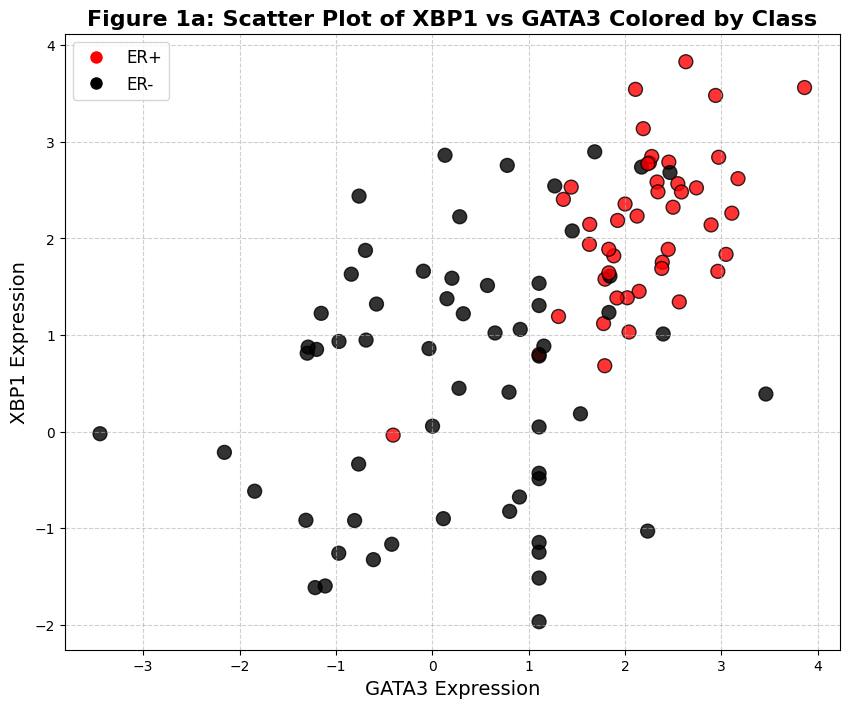

In [8]:
import matplotlib.pyplot as plt

colors = {0: 'black', 1: 'red'}

# Drop rows where 'class' is NaN
scatter_df_clean = scatter_df.dropna(subset=['class'])

# Convert class to int (only if all non-NaN are numeric)
scatter_df_clean['class'] = scatter_df_clean['class'].astype(int)
scatter_df_clean = scatter_df_clean.reset_index(drop=True)


# print(f"Number of rows after dropping NaN in 'class': {len(scatter_df_clean)}")
# print(scatter_df_clean.head())


# Scatter plot for XBP1 vs GATA3 expression
plt.figure(figsize=(10, 8))  # Increase figure size for better visibility
plt.scatter(
    scatter_df_clean['GATA3'], 
    scatter_df_clean['XBP1'], 
    c=scatter_df_clean['class'].map(colors), 
    alpha=0.8, 
    edgecolor='k',  # Add black edges to markers
    s=100  # Increase marker size
)

# Add labels and title
plt.xlabel('GATA3 Expression', fontsize=14)
plt.ylabel('XBP1 Expression', fontsize=14)
plt.title('Figure 1a: Scatter Plot of XBP1 vs GATA3 Colored by Class', fontsize=16, fontweight='bold')

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot with high resolution
plt.savefig('figure_1a_scatter_plot_improved.png', dpi=300, bbox_inches='tight')

# Show legend for classes
plt.legend(
    handles=[
                plt.Line2D([0], [0], marker='o', color='w', label='ER+', 
                                    markerfacecolor=colors[1], markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', label='ER-', 
                                    markerfacecolor=colors[0], markersize=10)
            ],
    loc='upper left', fontsize=12
)

# Display the plot
plt.show()


## Prepare Data for PCA

To apply PCA, we format the data so that:

- **Rows = Patients**
- **Columns = Features (genes: XBP1, GATA3)**

PCA will find the directions (principal components) along which the variation in the data is maximized. In this case, we'll reduce the 2D feature space into new, orthogonal axes.


In [9]:
data_for_pca = np.column_stack((scatter_df_clean['GATA3'], scatter_df_clean['XBP1']))
print(f"Data for PCA shape: {data_for_pca.shape} (samples x genes)")


Data for PCA shape: (105, 2) (samples x genes)


In [10]:
# PCA implementation

def PCA(X):
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # Compute covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False)
    
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    
    return X_centered, sorted_eigenvectors, sorted_eigenvalues   # Return PCA components and explained variance


## Apply PCA

We apply PCA to the 2D gene expression data. The first principal component (PC1) captures the most variance, and the second (PC2) captures the next highest orthogonal variance.

These components represent a rotated coordinate system better aligned with the structure in the data.


In [11]:
# Perform PCA on the expression data

X_centered, eigenvectors, eigenvalues = PCA(data_for_pca)


In [12]:
# Select the first two principal components

pca_1 = eigenvectors[:, 0]
pca_2 = eigenvectors[:, 1]

# Project the data onto the first two principal components
projection_1 = np.dot(X_centered, pca_1)
projection_2 = np.dot(X_centered, pca_2)


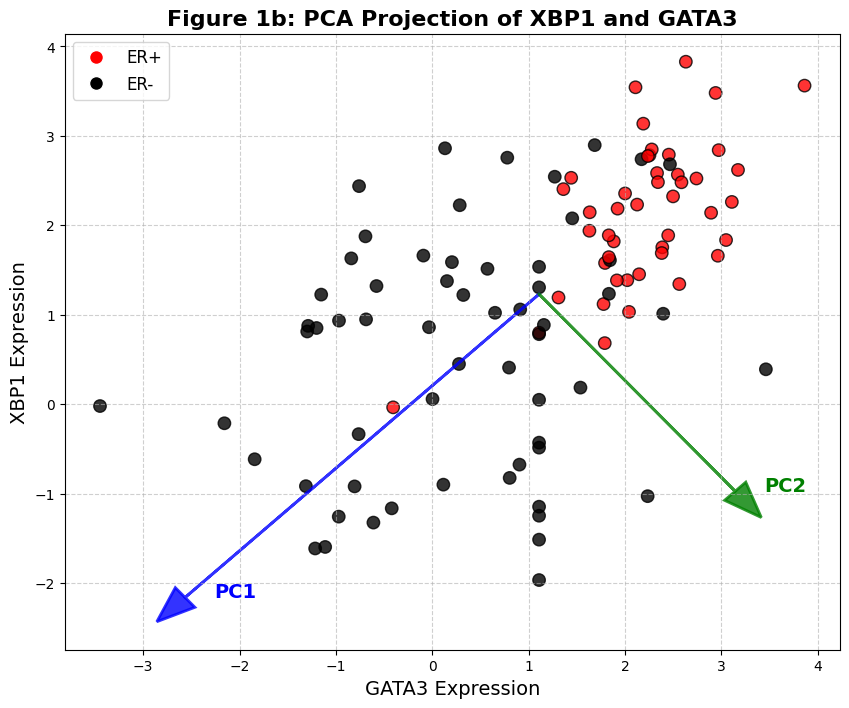

In [13]:
# Plot the Figure 1b, the PCA projection lines.

# Calculate means for GATA3 and XBP1
gata3_mean = np.mean(scatter_df['GATA3'])
xbp1_mean = np.mean(scatter_df['XBP1'])


# First create the scatter plot of Figure 1a
plt.figure(figsize=(10, 8))
plt.scatter(
    scatter_df['GATA3'], 
    scatter_df['XBP1'], 
    c=scatter_df_clean['class'].map(colors), 
    alpha=0.8, 
    edgecolor='k', 
    s=80,  # Increase marker size for better visibility
    label='Samples'
)

# Add PCA arrows
plt.arrow(
    gata3_mean, xbp1_mean, pca_1[0]*5, pca_1[1]*5, 
    head_width=0.3, head_length=0.4, fc='blue', ec='blue', linewidth=2, alpha=0.8
)
plt.arrow(
    gata3_mean, xbp1_mean, pca_2[0]*3, pca_2[1]*3, 
    head_width=0.3, head_length=0.4, fc='green', ec='green', linewidth=2, alpha=0.8
)

# Add labels for PCA components
plt.text(
    gata3_mean + pca_1[0]*5 + 0.3, xbp1_mean + pca_1[1]*5, 
    'PC1', fontsize=14, color='blue', fontweight='bold'
)
plt.text(
    gata3_mean + pca_2[0]*3 + 0.3, xbp1_mean + pca_2[1]*3, 
    'PC2', fontsize=14, color='green', fontweight='bold'
)

# Add labels, title, and grid
plt.xlabel('GATA3 Expression', fontsize=14)
plt.ylabel('XBP1 Expression', fontsize=14)
plt.title('Figure 1b: PCA Projection of XBP1 and GATA3', fontsize=16, fontweight='bold')

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show legend for classes
plt.legend(
    handles=[
                plt.Line2D([0], [0], marker='o', color='w', label='ER+', 
                                    markerfacecolor=colors[1], markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', label='ER-', 
                                    markerfacecolor=colors[0], markersize=10)
            ],
    loc='upper left', fontsize=12
)

# Save and show the plot
plt.savefig('figure_1b_pca_projection_arrows_improved.png', dpi=300, bbox_inches='tight')
plt.show()


## PCA Projection Plot

We project the patient samples onto the first two principal components and plot them with ER status:

- **Red** = ER⁺
- **Black** = ER⁻

This visualizes how PCA transforms the gene space and reveals class separability — replicating **Figure 1b/1c** from the original paper.


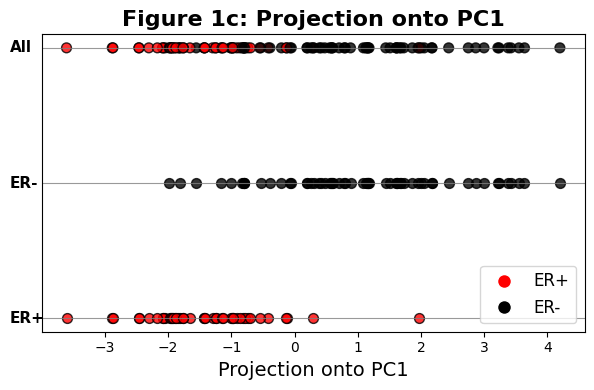

Variance explained by PC1: 0.7792
Variance explained by PC2: 0.2208


In [14]:
# Figure 1c: Projection onto PC1 is to be done.

ER_Plus = projection_1[scatter_df_clean['class'] == 1]
ER_Minus = projection_1[scatter_df_clean['class'] == 0]


# Create a single plot
plt.figure(figsize=(6, 4))

# Plot all samples
plt.scatter(projection_1, np.zeros_like(projection_1) + 1.5, c=scatter_df_clean['class'].map(colors), s=50, alpha=0.8, edgecolor='k', label='All')

# Plot ER- samples
plt.scatter(ER_Minus, np.zeros_like(ER_Minus) + 1, c='black', s=50, alpha=0.8, edgecolor='k', label='ER-')

# Plot ER+ samples
plt.scatter(ER_Plus, np.zeros_like(ER_Plus) + 0.5, c='red', s=50, alpha=0.8, edgecolor='k', label='ER+')

# Add horizontal reference lines
plt.axhline(1.5, color='gray', linestyle='-', linewidth=0.8, alpha=0.8)
plt.axhline(1, color='gray', linestyle='-', linewidth=0.8, alpha=0.8)
plt.axhline(0.5, color='gray', linestyle='-', linewidth=0.8, alpha=0.8)

# Add labels for each group
plt.text(-4.5, 1.5, 'All', fontsize=11, verticalalignment='center', fontweight='bold')
plt.text(-4.5, 1, 'ER-', fontsize=11, verticalalignment='center', fontweight='bold')
plt.text(-4.5, 0.5, 'ER+', fontsize=11, verticalalignment='center', fontweight='bold')

# Add axis labels and title
plt.xlabel('Projection onto PC1', fontsize=14)
plt.yticks([])  # Remove y-axis ticks
plt.title('Figure 1c: Projection onto PC1', fontsize=16, fontweight='bold')

# Show legend for classes
plt.legend(
    handles=[
                plt.Line2D([0], [0], marker='o', color='w', label='ER+', 
                                    markerfacecolor=colors[1], markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', label='ER-', 
                                    markerfacecolor=colors[0], markersize=10)
            ],
    loc='lower right', fontsize=12
)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('figure_1c_projection_pc1_combined.png', dpi=300, bbox_inches='tight')
plt.show()


# Calculate and print variance explained
print(f"Variance explained by PC1: {eigenvalues[0]/sum(eigenvalues):.4f}")
print(f"Variance explained by PC2: {eigenvalues[1]/sum(eigenvalues):.4f}")


# Summary

- We visualized key gene expression differences between ER+ and ER- breast cancer patients.
- PCA revealed clear separation of patients based on gene expression profiles.
- These unsupervised methods help identify hidden patterns in high-dimensional biological data.


